# Association Analysis

In [1]:
import NotebookImport
from DX_screen import *

importing IPython notebook from DX_screen

importing IPython notebook from Imports

importing IPython notebook from Setup/DX_Imports

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


In [2]:
def odds_ratio_df(a,b):
    a = a.astype(int)
    b = b.astype(int)
    flip = lambda v: (v == 0).astype(int)

    a11 = (a.add(b) == 2).sum(axis=1)
    a10 = (a.add(flip(b)) == 2).sum(axis=1)
    a01 = (flip(a).add(b) == 2).sum(axis=1)
    a00 = (flip(a).add(flip(b)) == 2).sum(axis=1)
    odds_ratio = (1.*a11 * a00) / (1.*a10 * a01)
    df = pd.concat([a00, a01, a10, a11], axis=1,
                   keys=['00','01','10','11'])
    return odds_ratio, df

In [3]:
ann = DX.probe_annotations
ann.Genomic_Coordinate = ann.Genomic_Coordinate.astype(float)
ann = ann.ix[dx_meth.index.intersection(ann.index)]
ann = ann.sort(['Chromosome','Genomic_Coordinate'])

In [4]:
dr = matched_rna.xs('01',1,1) > matched_rna.xs('11',1,1)
dm = matched_meth.xs('01',1,1) > matched_meth.xs('11',1,1)
gene_lookup = ann.Gene_Symbol.dropna()
gene_lookup = gene_lookup[gene_lookup.isin(dr.index)]
dm = dm.ix[gene_lookup.index]
dr = dr.ix[:, dr.columns.intersection(dm.columns)]
dm = dm.ix[:, dr.columns.intersection(dm.columns)]

In [5]:
dr_x = dr.ix[gene_lookup] * 1.
dr_x.index = gene_lookup.index
dm_x = dm.ix[gene_lookup.index] * 1.

odds_ratio, df_odds_ratio = odds_ratio_df(dr_x, dm_x)

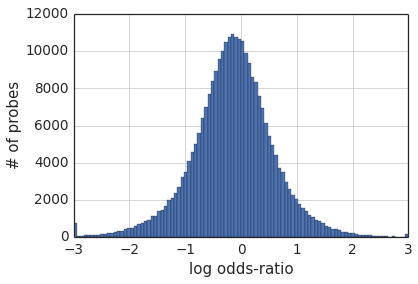

In [13]:
fig, ax = subplots(figsize=(6,4))
log_odds = np.log2(odds_ratio).clip(-3,3)
log_odds.hist(bins=100)
ax.set_xlabel('log odds-ratio')
ax.set_ylabel('# of probes')

Odds ratio associations across genome annotations

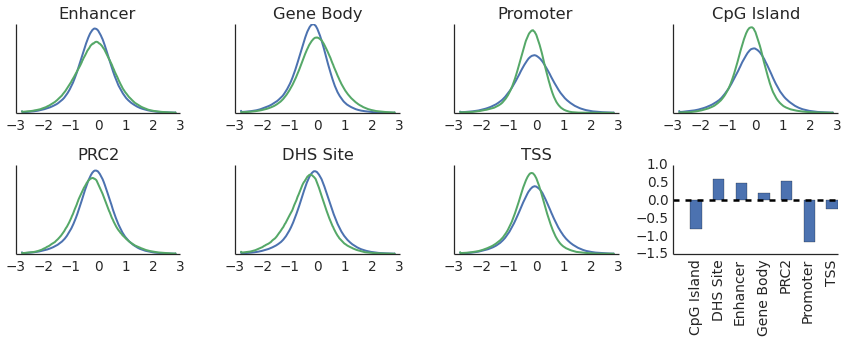

In [7]:
fig, axs = subplots(2,4, figsize=(12,5))
axs = axs.flatten()
for i,p in enumerate(DX.probe_sets.keys()):
    draw_dist(log_odds, DX.probe_sets[p], ax=axs[i])
    axs[i].legend().set_visible(False)
    axs[i].set_yticks([])
    axs[i].set_title(p)
    prettify_ax(axs[i])
f_odds = pd.DataFrame({f: fisher_exact_test(log_odds.abs().dropna() > 1, v)
                      for f,v in DX.probe_sets.iteritems()}).T
np.log2(f_odds.odds_ratio).plot(kind='bar', ax=axs[-1])
prettify_ax(axs[-1])
fig.tight_layout()

In [8]:
pd.Series({s: sum(v*1.) for s,v in DX.probe_sets.iteritems()})

CpG Island    130023
DHS Site       59916
Enhancer      102559
Gene Body     175571
PRC2           79082
Promoter       98090
TSS           140003
dtype: float64

In [9]:
gl = {}
for p in DX.probe_sets:
    ss = ti(DX.probe_sets[p])
    m = log_odds.ix[ss].groupby(gene_lookup).mean().dropna().order()
    s = log_odds.ix[ss].groupby(gene_lookup).size()
    s = s[s.index.isin(dx_rna.index)]
    g = m.ix[ti(s > 10)]
    gl[p] = pd.concat([g,s], keys=['g','s'], axis=1).dropna().sort('g')

In [10]:
pd.concat(gl, axis=1).fillna(0).sort([('Gene Body','g')]).replace(0,'')

CpG Island      DHS Site     Enhancer     Gene Body              PRC2      Promoter         TSS    
                  g    s        g   s        g   s         g         s       g    s        g   s       g   s
TBX3         -0.621   13                               -2.06        12   -1.28   29                         
DUSP6         0.054   16                               -2.04        11   -1.86   14               0.0947  12
RAB34                                                  -1.82        12                                      
KIAA1949   -0.00537   22     -0.4  37                  -1.75        43                -0.941  58            
KRT7          -1.57   12    -1.49  11                  -1.71        11   -1.59   15                         
BNC1          -1.76   20    -1.38  22                  -1.71        12   -1.14   31               -0.783  19
DLL4         -0.654   19                               -1.66        12  -0.807   24                         
GATA3                                   -0.963  11     -1.63        21   -1.69   24                         
TRIM29                                                 -1.62        14                                      
TCF7         -0.659   13                               -1.58        14                 -0.88  11  -0.919  17
ANXA2                                                  -1.53        13                            -0.694  11
GRASP                       -1.63  15                   -1.5        13   -1.25   22                         
SCNN1A                                   -1.13  11     -1.49        22                             -1.94  13
HLA-B        -0.229   13                               -1.49        13  -0.941   21   -0.389  12            
HLA-E        -0.977   27                               -1.47        42                -0.873  32            
HCG4          -1.42   25    -1.47  27                  -1.45        27                 -1.42  25            
TNFRSF1A                                               -1.43        13                                      
SEMA4C        -0.36   13                               -1.43        15                                      
APOLD1       -0.196   17                                -1.4        14   -1.51   12   -0.329  17  -0.951  17
SLC6A8                                                 -1.39        12                            -0.768  15
IFFO1         -1.89   13                               -1.38        19                             -2.43  11
SLC1A5                                                 -1.38        12                -0.865  21  -0.735  17
DPP4                                                   -1.33        11   -1.53   11                         
C1QTNF7                                                -1.29        19                             -1.81  12
SP8           -1.23   11                               -1.26        17   -1.17   20                         
GNAI2                                    -1.29  11     -1.25        19                 -1.01  17            
NFIX         -0.293   24    -1.43  22    -1.17  25     -1.25        52  -0.918   68                         
HLA-F        -0.972   30   -0.969  35     -1.1  28     -1.23        38   -1.02   50   -0.934  34            
EPHA7         -1.39   17    -1.43  16                  -1.23        11                                      
SLC39A7                                                 -1.2        12                                      
...             ...  ...      ...  ..      ...  ..       ...       ...     ...  ...      ...  ..     ...  ..
SRCIN1                                    1.01  24      1.23        46    1.06   42                         
OLFM1                                                   1.26        24   0.222   11                         
PAX1          0.501   15                 0.569  16      1.27        14    0.92   31                0.571  11
SDK1          0.785   20                  1.31  44      1.28       247               

Odds Ratio associations across individual gene annotations

In [91]:
m = log_odds.groupby(gene_lookup).mean().dropna().order()
s = log_odds.groupby(gene_lookup).size()
s = s[s.index.isin(dx_rna.index)]
g = m.ix[ti(s > 20)]
pd.concat([g,s], keys=['g','s'], axis=1).dropna().sort('g').head(10)

,g,s
IFFO1,-1.77,31
PON3,-1.67,25
KRT7,-1.63,23
FERMT3,-1.61,21
GRHL2,-1.53,34
TRIM29,-1.52,27
GATA3,-1.50,28
SCNN1A,-1.49,28
GPT,-1.47,28
HCG4,-1.45,28


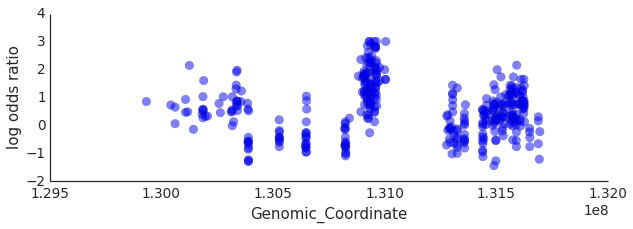

In [141]:
fig, ax = subplots(figsize=(10,3))
a = ann[ann.Gene_Symbol == 'RIMBP2']
v = a.Genomic_Coordinate
v2 = ann[(ann.Chromosome == a.Chromosome.iloc[0]) & 
         (ann.Genomic_Coordinate > v.min() -1000000) & 
         (ann.Genomic_Coordinate < v.max() + 1000000)].Genomic_Coordinate
series_scatter(v2, log_odds, ax=ax, ann=None)
ax.set_ylabel('log odds ratio')
prettify_ax(ax)

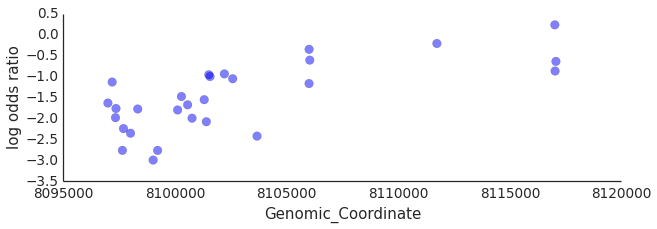

In [107]:
fig, ax = subplots(figsize=(10,3))
v = ann[ann.Gene_Symbol == 'GATA3'].Genomic_Coordinate
series_scatter(v, log_odds, ax=ax, ann=None)
ax.set_ylabel('log odds ratio')
prettify_ax(ax)

In [11]:
m = log_odds.groupby(gene_lookup).mean().dropna().order()
s = log_odds.groupby(gene_lookup).size()
s = s[s.index.isin(dx_rna.index)]
g = m.ix[ti(s > 10)]
pd.concat([g,s], keys=['g','s'], axis=1).dropna().sort('g').tail(10)

,g,s
C20orf160,1.28,15
CDH4,1.31,90
HOTAIR,1.32,16
PTPRN2,1.40,1051
TBL1Y,1.46,11
KNDC1,1.48,115
RHPN1,1.52,23
RASAL3,1.53,13
RIMBP2,1.58,98
WIT1,1.73,14


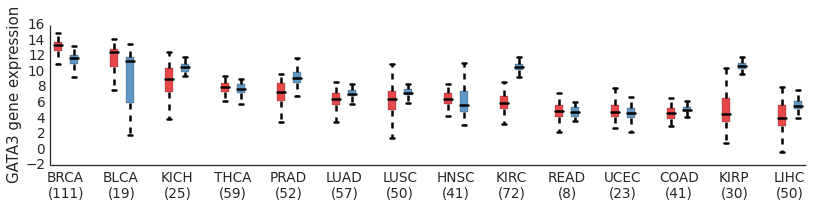

In [105]:
fig, ax = subplots(figsize=(12,3))
paired_bp_tn_split(matched_rna.ix['GATA3'], codes, ax=ax)

In [94]:
draw_dist?

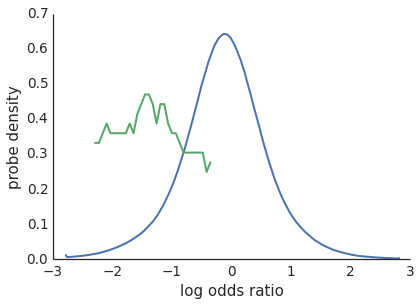

In [104]:
fig, ax = subplots()
draw_dist(log_odds, ax=ax)
draw_dist(log_odds.ix[ti(gene_lookup == 'GATA3')], ax=ax, bins=50)
prettify_ax(ax)
ax.set_xlabel('log odds ratio')
ax.set_ylabel('probe density')

In [17]:
log_odds.ix[ti(gene_loakup == 'PTPRN2')]

Hybridization REF
cg00449390          -1.49
cg10218605          -1.38
cg19208749          -1.06
cg10554264          -0.95
cg25910261          -0.67
cg05119831          -0.64
cg22970003          -0.51
cg22282410          -0.50
cg09194449          -0.49
cg14419740          -0.46
cg16627193          -0.38
cg04799270          -0.31
cg14001157          -0.28
cg23455837          -0.21
cg00541104          -0.18
...
cg22420514           3
cg01536803           3
cg03899215           3
cg24996491           3
cg06413087           3
cg04135434           3
cg14468481           3
cg19212465           3
cg01262413           3
cg11468861           3
cg17167790           3
cg06555227           3
cg18099070           3
cg15192120           3
cg25481630           3
Length: 1051, dtype: float64

In [12]:
pd.concat([g,s], keys=['g','s'], axis=1).dropna().sort('g').head(10)

,g,s
S1PR4,-2.59,12
IFITM1,-2.43,13
REC8,-2.22,14
ZNF578,-2.10,17
LOC134466,-2.07,13
ZNF454,-2.01,13
SPN,-2.00,15
TMEM88,-2.00,14
BIN2,-1.96,15
LAT,-1.96,14


In [13]:
   gs3 = pd.DataFrame({p: gene_lookup.isin(ti(v>0)) for p,v in gs2.iteritems()})

In [14]:
gs4 = gs3.ix[ti(DX.gene_body)].dropna()

In [15]:
rr_b = screen_feature(log_odds.ix[gs4.index].abs(), rev_kruskal, gs4.T, 
                      align=False)

In [16]:
rr_b.head()

,H,p,q
KEGG_CELL_ADHESION_MOLECULES_CAMS,219.11,1.41e-49,1.18e-46
REACTOME_CELL_CYCLE_MITOTIC,177.01,2.18e-40,9.07e-38
REACTOME_SIGNALING_IN_IMMUNE_SYSTEM,123.86,9.06e-29,2.51e-26
REACTOME_MITOTIC_PROMETAPHASE,111.68,4.20e-26,8.74e-24
REACTOME_CELL_CYCLE_CHECKPOINTS,104.87,1.30e-24,2.17e-22


In [17]:
gs5 = gs3.ix[ti(DX.dhs_site)].dropna()

In [18]:
rr_prc = screen_feature(log_odds.ix[gs5.index], rev_kruskal, gs5.T, 
                      align=False)

In [19]:
rr_prc.head()

,H,p,q
KEGG_GLYCOSPHINGOLIPID_BIOSYNTHESIS_GANGLIO_SERIES,71.86,2.31e-17,1.92e-14
BIOCARTA_VIP_PATHWAY,62.53,2.63e-15,1.09e-12
BIOCARTA_TCR_PATHWAY,46.10,1.12e-11,3.11e-09
SIG_BCR_SIGNALING_PATHWAY,42.80,6.08e-11,1.26e-08
BIOCARTA_CALCINEURIN_PATHWAY,41.00,1.52e-10,2.53e-08


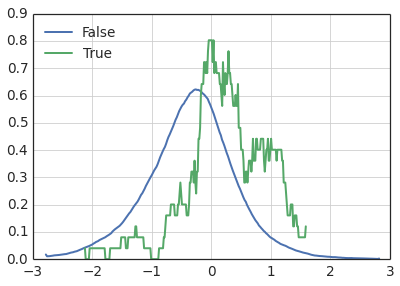

In [20]:
v = gene_lookup.isin(ti(gs2['BIOCARTA_VIP_PATHWAY']>0))
draw_dist(log_odds, v.ix[ti(DX.dhs_site)])

In [21]:
rr_p = screen_feature(log_odds.ix[gs5.index], rev_kruskal, gs5.T, 
                      align=False)
rr_p.head(3)

,H,p,q
KEGG_GLYCOSPHINGOLIPID_BIOSYNTHESIS_GANGLIO_SERIES,71.86,2.31e-17,1.92e-14
BIOCARTA_VIP_PATHWAY,62.53,2.63e-15,1.09e-12
BIOCARTA_TCR_PATHWAY,46.10,1.12e-11,3.11e-09


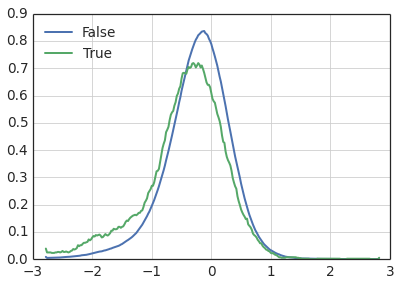

In [22]:
v = gene_lookup.isin(ti(gs2['REACTOME_SIGNALING_IN_IMMUNE_SYSTEM']>0))
draw_dist(log_odds, v.ix[ti(DX.promoter)])

In [23]:
gs5 = gs3.ix[ti(DX.promoter)].dropna()

In [24]:
rr_f = screen_feature(log_odds.ix[gs3.index].abs(), rev_kruskal, gs3.T, 
                      align=False)

In [25]:
fp = (1.*gs3.T * log_odds.abs()).T.dropna().replace(0, np.nan).mean().order()
fp.name = 'mean LOD'

In [26]:
rr_f.ix[ti(fp < fp.mean())].join(fp).sort('p').head(3)

,H,p,q,mean LOD
REACTOME_CELL_CYCLE_MITOTIC,218.64,1.79e-49,7.46e-47,0.46
REACTOME_GENE_EXPRESSION,214.35,1.54e-48,4.27e-46,0.46
REACTOME_FORMATION_AND_MATURATION_OF_MRNA_TRANSCRIPT,184.09,6.20e-42,1.29e-39,0.40


In [27]:
rr_f.ix[ti(fp > fp.mean())].join(fp).sort('p').head(5)

,H,p,q,mean LOD
KEGG_CELL_ADHESION_MOLECULES_CAMS,296.64,1.78e-66,1.48e-63,0.79
REACTOME_SIGNALING_IN_IMMUNE_SYSTEM,180.40,3.96e-41,6.58e-39,0.68
REACTOME_GENERATION_OF_SECOND_MESSENGER_MOLECULES,146.45,1.03e-33,8.60e-32,0.89
REACTOME_PD1_SIGNALING,145.12,2.03e-33,1.53e-31,0.91
REACTOME_PHOSPHORYLATION_OF_CD3_AND_TCR_ZETA_CHAINS,143.93,3.68e-33,2.55e-31,0.93


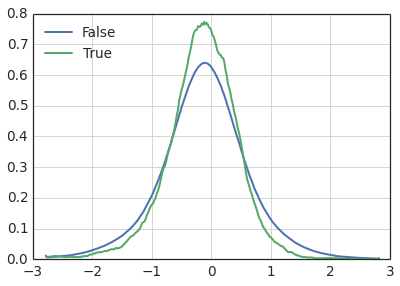

In [28]:
v = gene_lookup.isin(ti(gs2['REACTOME_CELL_CYCLE_MITOTIC']>0))
draw_dist(log_odds, v)

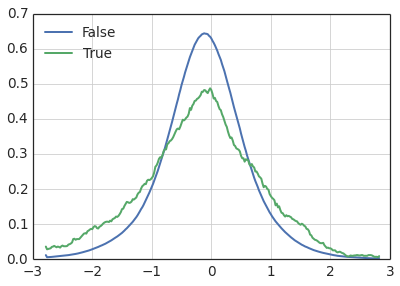

In [29]:
v = gene_lookup.isin(ti(gs2['KEGG_CELL_ADHESION_MOLECULES_CAMS']>0))
draw_dist(log_odds, v)

In [30]:
pd.concat([g.ix[ti(gs2['KEGG_CELL_ADHESION_MOLECULES_CAMS']>0)],
           s], keys=['g','s'], axis=1).dropna().sort('g').head(10)

,g,s
SPN,-2.00,15
CD40,-1.52,15
CD34,-1.50,17
CLDN7,-1.41,13
HLA-E,-1.25,57
HLA-A,-1.23,14
ICAM2,-1.18,11
CLDN15,-1.17,11
CLDN19,-1.13,13
OCLN,-1.08,14
